# Problem Set 2

Solutions to Computational Problems

## Problem 2

In [1]:
from functools import partial
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from scipy.stats import norm

## Functions

In [2]:
def simulate_from_model(
    n_sim: int,
    n_periods: int,
    alpha: float,
    rng: np.random.Generator,
):
    """Simulate from AR(1) model.

    Args:
        n_sim (int): Number of simulations.
        n_periods (int): Number of periods.
        alpha (float): AR(1) parameter.
        rng (np.random.Generator): Random number generator.

    Returns:
        np.ndarray: Simulated data. Has shape (n_periods, n_sim).

    """
    # draw error terms
    cov = np.identity(n_periods + 1)
    cov[0, 0] /= 1 - alpha**2

    error = rng.multivariate_normal(mean=np.zeros(n_periods + 1), cov=cov, size=n_sim).T

    # initialize starting value
    y = np.empty_like(error)
    y[0] = error[0]

    # iterate over periods
    for t in range(1, n_periods + 1):
        y[t] = alpha * y[t - 1] + error[t]

    return y[1:]  # drop period zero

In [3]:
def compute_ols_coef(y: np.ndarray):
    """Computes the OLS estimator of the AR(1) coefficient.

    Args:
        y (np.ndarray): Time series data. Has shape (n_periods, n_sim).

    Returns:
        np.ndarray: OLS estimate of the AR(1) coefficient. Has shape (n_sim,).

    """
    # extract independent and dependent variable
    y_lagged = y[:-1]
    y = y[1:]

    # compute coefficients
    return np.sum(y * y_lagged, axis=0) / np.sum(y_lagged**2, axis=0)

In [4]:
def compute_ols_se(coef: np.ndarray, n_periods: int):
    """Computes the standard error of the OLS estimator of the AR(1) coefficient.

    Args:
        coef (np.ndarray): The OLS estimate of the AR(1) coefficient. Has shape (n_sim,)
        n_periods (int): The number of periods in the time series.

    Returns:
        np.ndarray: The standard error of the OLS estimator of the AR(1) coefficient.
            Has shape (n_sim,).

    """
    return np.sqrt(np.abs(1 - coef**2) / n_periods)

In [5]:
def compute_ols_confidence_interval(
    coef: np.ndarray,
    se: np.ndarray,
    significance_level: float,
):
    """Computes the confidence interval for the OLS coefficient.

    Args:
        coef (np.ndarray): The OLS estimate of the AR(1) coefficient. Has shape (n_sim,)
        se (np.ndarray): The standard error of the OLS estimator. Has shape (n_sim,)
        significance_level (float): The significance level.

    Returns:
        - np.ndarray: The lower bound of the confidence interval. Has shape (n_sim,).
        - np.ndarray: The upper bound of the confidence interval. Has shape (n_sim,).

    """
    lower = coef - norm.ppf(1 - significance_level / 2) * se
    upper = coef + norm.ppf(1 - significance_level / 2) * se
    return lower, upper

In [6]:
def _simulation(
    n_sim: int,
    n_periods: int,
    alpha: float,
    significance_level: float,
    rng: np.random.Generator,
):
    """Perform a monte carlo simulation.

    Args:
        n_sim (int): Number of simulations.
        n_periods (int): Number of periods.
        alpha (float): AR(1) parameter.
        significance_level (float): Significance level.
        rng (np.random.Generator): Random number generator.

    Returns:
        pd.DataFrame: Dataframe containing the averaged metrics.

    """
    # simulate data
    y = simulate_from_model(
        n_sim=n_sim,
        n_periods=n_periods,
        alpha=alpha,
        rng=rng,
    )

    # estimate coefficient and standard error
    coef = compute_ols_coef(y)

    se = compute_ols_se(coef, n_periods=n_periods)

    # compute confidence interval
    lower, upper = compute_ols_confidence_interval(
        coef,
        se=se,
        significance_level=significance_level,
    )

    # track squared error
    squared_error = (coef - alpha) ** 2

    # calculate coverage
    coverage = np.logical_and(lower <= alpha, alpha <= upper)

    # collect results
    result = {
        "Estimate": coef,
        "Standard Error": se,
        "Coverage": coverage,
    }

    # take mean across simulations
    result = pd.DataFrame(result).mean(axis=0)
    result["RMSE"] = np.sqrt(np.mean(squared_error))
    return result

## Plot your function output

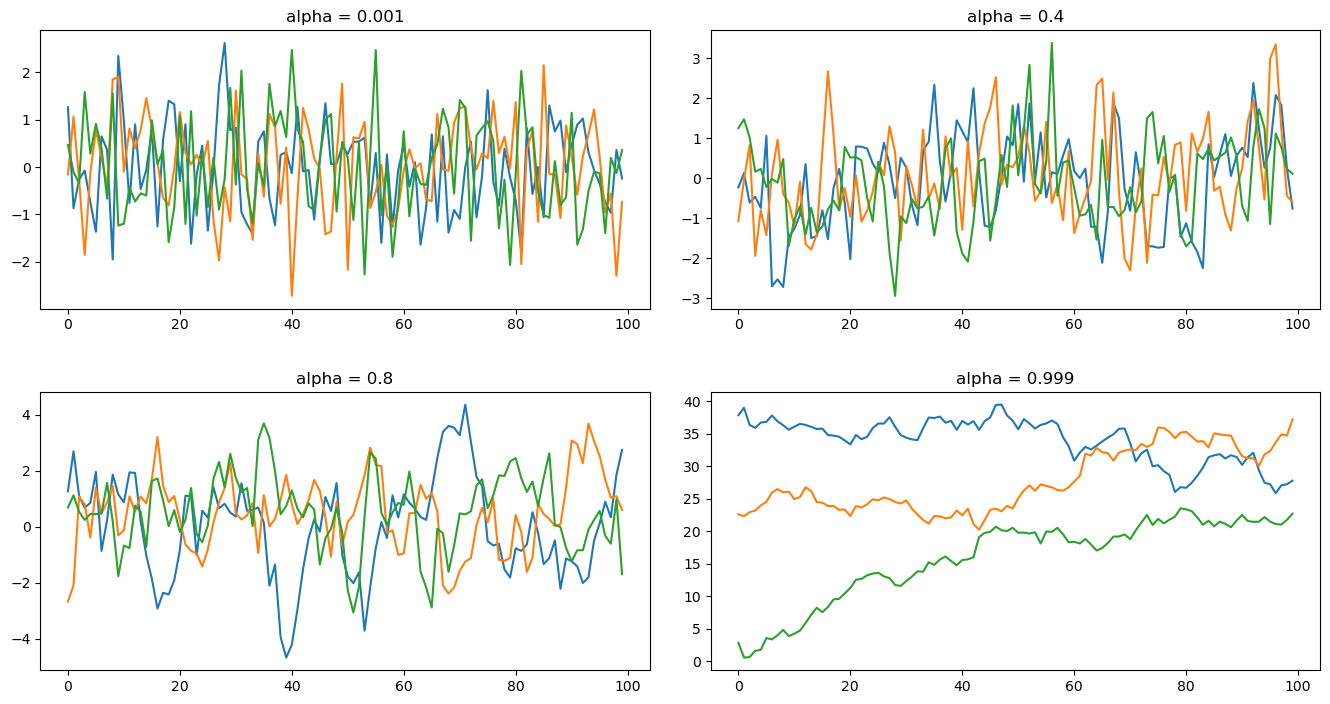

In [7]:
# plot the data created by the AR(1) simulation
rng = np.random.default_rng(12345)

alpha_grid = [0.001, 0.4, 0.8, 0.999]

fig, axs = plt.subplots(2, 2, figsize=(16, 8))

for alpha, ax in zip(alpha_grid, axs.flatten(), strict=True):
    data = simulate_from_model(n_sim=3, n_periods=100, alpha=alpha, rng=rng)
    sns.lineplot(data, dashes=False, legend=False, ax=ax).set(title=f"alpha = {alpha}")

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.3)
plt.show()

## Computation

In [8]:
rng = np.random.default_rng(54321)

alpha_grid = [0.99, 0.95, 0.9, 0.8, 0.7]
n_periods_grid = [200, 800]

simulation = partial(_simulation, n_sim=10_000, rng=rng, significance_level=0.05)

In [9]:
parameter_grid = list(product(alpha_grid, n_periods_grid))

raw_result = Parallel(n_jobs=5)(
    delayed(simulation)(alpha=alpha, n_periods=n_periods)
    for alpha, n_periods in parameter_grid
)

In [10]:
result = pd.DataFrame(
    raw_result,
    index=pd.MultiIndex.from_tuples(parameter_grid, names=["alpha", "No. Periods"]),
).T

In [11]:
result.round(4)

alpha             0.99            0.95            0.90            0.80  \
No. Periods        200     800     200     800     200     800     200   
Estimate        0.9820  0.9876  0.9410  0.9475  0.8910  0.8976  0.7916   
Standard Error  0.0123  0.0054  0.0234  0.0112  0.0317  0.0155  0.0429   
Coverage        0.9063  0.9467  0.9505  0.9477  0.9510  0.9501  0.9485   
RMSE            0.0179  0.0064  0.0270  0.0118  0.0342  0.0160  0.0445   

alpha                     0.70          
No. Periods        800     200     800  
Estimate        0.7978  0.6925  0.6981  
Standard Error  0.0213  0.0508  0.0253  
Coverage        0.9491  0.9458  0.9494  
RMSE            0.0216  0.0521  0.0256